## 분석 배경

#### POSCO 공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량발생의 근본 원인을 찾고 개선을 위한 최적의 조건을 도출하고자 한다.

### 잠재인자 선정
    : Scale 불량을 줄이기 위하여 엔지니어들과의 협의를 통하여 다음과 같은 잠재적 원인을 도출하였다.
- 가열로 가열대온도, 가열로 균열대온도, HSB, 사상압연온도, 압연간 디스케일링 횟수, 판두께

### ref. Domain knowledge

#### 압연공정에서 발생한 Scale은 "2차 Scale"으로 점형태를 띈다.
#### Scale은 가열로에서 너무 오래 있으면 융착됨으로 가열로 온도 조건과 시간이 중요하다.
#### 압연 종료 온도가 높으면 발생할 확률이 높다.


                                                                         - 출처: 포스코 포항 후판공장 방문 질의문답 -

# POSCO Manufacturing Process
<img src = "imgFolder/posco_pohang.png">

In [1]:
# 필요한 라이브러리를 불러온다.
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# 그림을 그릴 때, 폰트가 깨지지 않도록 한다.
import matplotlib.font_manager as fm
import matplotlib
import matplotlib.pyplot as plt
for f in fm.fontManager.ttflist:
    if 'NanumBarunGothic' in f.fname: plt.rcParams['font.family']='NanumBarunGothic'
    # 폰트 나눔고딕으로

print(plt.rcParams['font.family'])

matplotlib.rcParams['axes.unicode_minus'] = False # '-'기호 제대로 나오게

['NanumBarunGothic']


## 1. 데이터 불러오기

In [3]:
df = pd.read_csv("실습파일/SCALE불량.csv", engine = "python",encoding ='EUC-KR')
df.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


###  변수 설명
	
#####  PLATE_NO         
    : Plate No
#####  ROLLING_DATE    
    : 작업시각
##### SCALE            
    : Scale불량
##### SPEC             
    : 제품 규격
##### STEEL_KIND       
    : 강종
##### PT_THICK        
    : Plate 뚜께
##### PT_WIDTH   
    : Plate 폭
##### PT_LENGTH	  
    : Plate 길이
##### PT_WEIGHT	  
    : Plate 중량
##### FUR_NO    
    : 가열로 호기
##### FUR_NO_ROW  
    : 가열로 작업순번
##### FUR_HZ_TEMP   
    : 가열로 가열대 온도
##### FUR_HZ_TIME   
    : 가열로 가열대 시간
##### FUR_SZ_TEMP     
    : 가열로 균열대 온도
##### FUR_SZ_TIME  
    : 가열로 균열대 시간
##### FUR_TIME    
    : 가열로 시간
##### FUR_EXTEMP     
    : 가열로 추출온도
##### ROLLING_TEMP_T5  
    : 압연온도
##### HSB    
    : HSB적용(1-적용,0-미적용)
##### ROLLING_DESCALING	
    : 압연 중 Descaling 횟수
##### WORK_GR   
    : 작업조

## 2. 탐색적 데이터 분석(EDA)

In [4]:
# 데이터 형태 확인
df.shape

(720, 21)

In [5]:
# 결측치 확인
df.isnull().sum(axis=0)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

- 결측치는 없는 것으로 확인된다.

In [6]:
# 스케일 변수를 불량이면 1, 양품이면 0으로 변환
df["SCALE"].replace(to_replace = "양품", value = 0, inplace = True)
df["SCALE"].replace(to_replace = "불량", value = 1, inplace = True)
df.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [7]:
# 상관관계 확인
df.corr()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,1.000000,-0.124858,-0.206021,0.100475,0.218741,-0.022960,0.247670,0.056139,0.374809,-0.240137,-0.049214,0.374809,0.384967,-0.006955
PT_THK,-0.124858,1.000000,-0.313151,-0.862618,-0.397391,-0.002530,-0.523926,0.160110,-0.694770,0.113171,0.413009,-0.694770,-0.373976,-0.836631
PT_WDTH,-0.206021,-0.313151,1.000000,0.119726,0.031009,0.006727,0.180024,-0.119175,0.227296,0.022627,-0.393200,0.227296,-0.021807,0.337540
PT_LTH,0.100475,-0.862618,0.119726,1.000000,0.451815,-0.021185,0.473111,-0.077392,0.645402,-0.070225,-0.251950,0.645402,0.312762,0.809280
PT_WGT,0.218741,-0.397391,0.031009,0.451815,1.000000,-0.022241,0.153331,0.010491,0.359513,-0.190922,-0.057776,0.359513,0.263216,0.238986
FUR_NO_ROW,-0.022960,-0.002530,0.006727,-0.021185,-0.022241,1.000000,0.004753,-0.015791,0.009228,0.049045,0.016053,0.009228,-0.004372,0.018219
FUR_HZ_TEMP,0.247670,-0.523926,0.180024,0.473111,0.153331,0.004753,1.000000,-0.114395,0.772907,-0.222141,-0.348223,0.772907,0.265310,0.470899
FUR_HZ_TIME,0.056139,0.160110,-0.119175,-0.077392,0.010491,-0.015791,-0.114395,1.000000,-0.203401,0.177922,0.473137,-0.203401,0.011609,-0.137742
FUR_SZ_TEMP,0.374809,-0.694770,0.227296,0.645402,0.359513,0.009228,0.772907,-0.203401,1.000000,-0.450652,-0.477177,1.000000,0.452297,0.648646
FUR_SZ_TIME,-0.240137,0.113171,0.022627,-0.070225,-0.190922,0.049045,-0.222141,0.177922,-0.450652,1.000000,0.443176,-0.450652,-0.207358,-0.105667


- PT_변수끼리 높은 상관관계를 가진다.
- 또한 PT_변수와 ROLLING_DESCALING 변수도 높은 상관관계를 가진다.
- FUR_EXTEMP는 FUR_HZ_TEMP와 높은 상관관계를 가지며, FUR_SZ_TEMP와 상관관계가 1이다.(두 데이터가 같을 가능성이 높다.)

In [8]:
# 변수 중복 확인
tt = pd.DataFrame(df.FUR_SZ_TEMP == df.FUR_EXTEMP, columns=['is_same'])
tt.is_same.value_counts()

True    720
Name: is_same, dtype: int64

- FUR_SZ_TEMP 와 FUR_EXTEMP 데이터가 같은 데이터임을 확인했다.
- FUR_EXTEMP를 제거하기로 결정한다.

In [9]:
# 중복된 변수 제거
df_drop_fe =df.drop("FUR_EXTEMP", axis =1)
df_drop_fe.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,873,적용,8,1조


In [10]:
# 변수가 하나 줄었다.
df_drop_fe.shape

(720, 20)

In [11]:
# 파생변수 생성
# FUR_TIME는 FUR_HZ_TIME , FUR_SZ_TIME과 예열시간을 합친 시간이다.
# 따라서 FUR_TIME 을 지우고, 예열시간 파생변수인 FUR_PZ_TIME 을 생성하기로 결정한다.
df_drop_fe["FUR_PZ_TIME"] = df_drop_fe["FUR_TIME"] - df_drop_fe["FUR_HZ_TIME"] -df_drop_fe["FUR_SZ_TIME"]
df_fpt = df_drop_fe.drop("FUR_TIME", axis =1)
df_fpt.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,FUR_PZ_TIME
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,934,적용,8,2조,107
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,937,적용,8,2조,108
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,889,적용,8,3조,111
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,885,적용,8,3조,123
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,873,적용,8,1조,132


In [12]:
#  ID 변수 : PLATE_NO, 작업시작시간 : ROLLING_DATE 제거 
df_drop_pln_rd = df_fpt.drop(["PLATE_NO","ROLLING_DATE"], axis =1)
df_drop_pln_rd.shape

(720, 18)

- shape변화 : (720, 20) -> (720, 18)

In [13]:
# FUR_NO_ROW는 순번이므로 범주형 변수로 형변환
# 데이터를 타입에 맞게 분할하여 EDA진행
df_drop_pln_rd['FUR_NO_ROW']= df_drop_pln_rd['FUR_NO_ROW'].astype(str)

In [14]:
df_drop_pln_rd.shape

(720, 18)

In [15]:
# EDA를 위해 범주형 데이터와 숫자형 데이터로 분할한다.
df_numeric = df_drop_pln_rd.select_dtypes(exclude="object")
df_category = df_drop_pln_rd.select_dtypes(include="object")

In [16]:
df_numeric.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_PZ_TIME
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.320833,29.267857,2807.127778,34323.269444,41481.777778,1155.338889,88.527778,1149.666667,78.802778,933.920833,8.319444,133.233333
std,0.467121,19.152651,517.839690,13828.434837,24751.322015,20.866398,37.660799,17.571788,36.421004,107.863887,1.623252,47.014051
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1103.000000,43.000000,1113.000000,35.000000,0.000000,5.000000,-35.000000
25%,0.000000,16.090000,2466.000000,22663.000000,17757.500000,1139.000000,65.000000,1132.000000,57.750000,889.750000,6.000000,113.000000
50%,0.000000,20.130000,2725.000000,37380.000000,36120.000000,1158.000000,75.000000,1155.000000,67.500000,951.000000,8.000000,129.000000
75%,1.000000,40.000000,3125.000000,43735.000000,61120.000000,1171.000000,101.000000,1164.000000,86.000000,994.250000,10.000000,163.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,1206.000000,312.000000,1185.000000,294.000000,1078.000000,10.000000,271.000000


In [17]:
df_numeric.corr()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_PZ_TIME
SCALE,1.000000,-0.124858,-0.206021,0.100475,0.218741,0.247670,0.056139,0.374809,-0.240137,0.384967,-0.006955,0.093546
PT_THK,-0.124858,1.000000,-0.313151,-0.862618,-0.397391,-0.523926,0.160110,-0.694770,0.113171,-0.373976,-0.836631,0.182816
PT_WDTH,-0.206021,-0.313151,1.000000,0.119726,0.031009,0.180024,-0.119175,0.227296,0.022627,-0.021807,0.337540,-0.301683
PT_LTH,0.100475,-0.862618,0.119726,1.000000,0.451815,0.473111,-0.077392,0.645402,-0.070225,0.312762,0.809280,-0.126851
PT_WGT,0.218741,-0.397391,0.031009,0.451815,1.000000,0.153331,0.010491,0.359513,-0.190922,0.263216,0.238986,0.083720
FUR_HZ_TEMP,0.247670,-0.523926,0.180024,0.473111,0.153331,1.000000,-0.114395,0.772907,-0.222141,0.265310,0.470899,-0.072470
FUR_HZ_TIME,0.056139,0.160110,-0.119175,-0.077392,0.010491,-0.114395,1.000000,-0.203401,0.177922,0.011609,-0.137742,-0.482092
FUR_SZ_TEMP,0.374809,-0.694770,0.227296,0.645402,0.359513,0.772907,-0.203401,1.000000,-0.450652,0.452297,0.648646,0.051352
FUR_SZ_TIME,-0.240137,0.113171,0.022627,-0.070225,-0.190922,-0.222141,0.177922,-0.450652,1.000000,-0.207358,-0.105667,-0.489339
ROLLING_TEMP_T5,0.384967,-0.373976,-0.021807,0.312762,0.263216,0.265310,0.011609,0.452297,-0.207358,1.000000,0.267521,-0.041130


In [18]:
df_category.describe()

,SPEC,STEEL_KIND,FUR_NO,FUR_NO_ROW,HSB,WORK_GR
count,720,720,720,720,720,720
unique,66,9,3,2,2,4
top,JS-SM490YB,C0,3호기,1,적용,4조
freq,84,503,243,362,687,194


- 대부분 HSB를 적용하는 것을 알 수 있다.(데이터 불균형 의심)

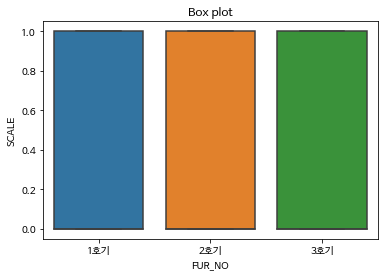

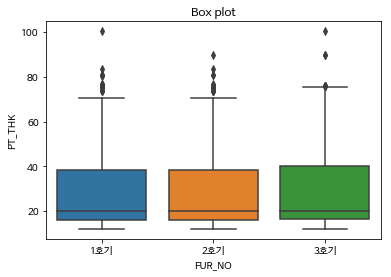

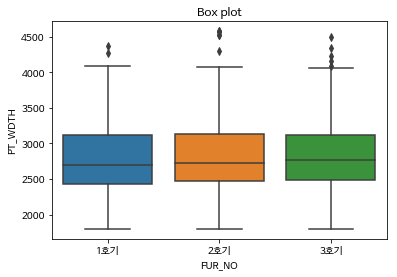

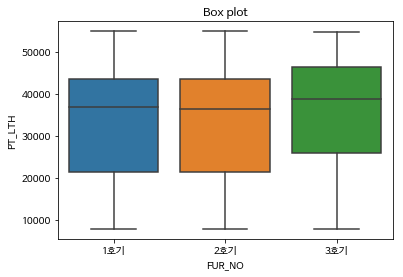

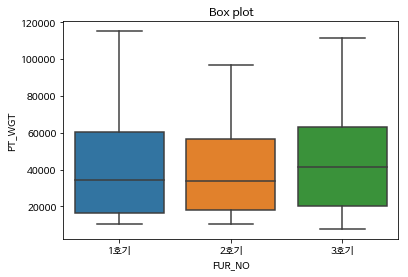

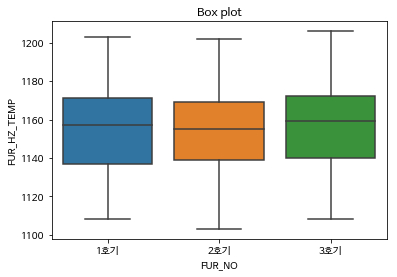

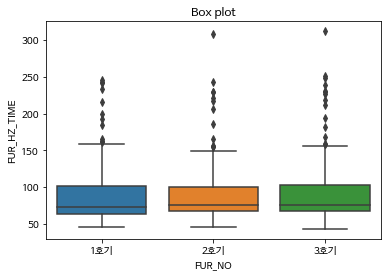

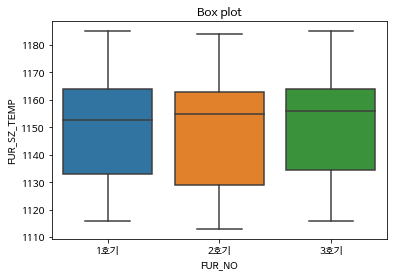

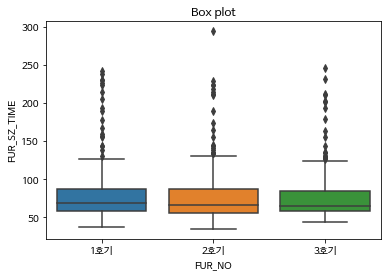

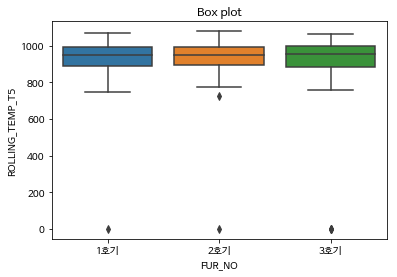

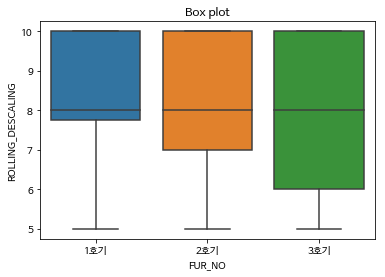

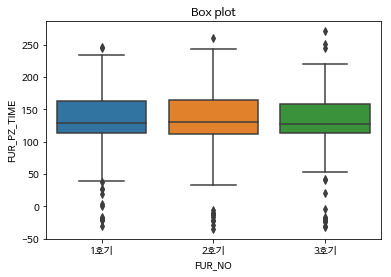

In [19]:
for i in df_numeric.columns:
    
    sns.boxplot(x='FUR_NO',y=i, data = df_drop_pln_rd)
    plt.title("Box plot")
    plt.show()

- 가열로 호기별로 온도, 시간 등의 차이는 분명히 존재한다.(가열로 호기는 설명변수로 넣자.)
- ROLLING_TEMP_T5 가 0에 가까운 점들이 존재한다. -> 확인해 볼 필요성이 있다.

In [20]:
def fun_print_crosstab(data, var):
    print("[SCALE count by %s]\n"%i )
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print("[SCALE rate by %s]\n"%i )
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize="columns").round(3))
    print()
    
for i in df_category.columns:
    fun_print_crosstab(df_drop_pln_rd,i)

[SCALE count by SPEC]

SPEC   A131-DH36TM  A283-C  A516-60  A709-36  AB/A  AB/AH32  AB/B  AB/EH32-TM  \
SCALE                                                                           
0                0       1        1        1     3        4     3           2   
1                1       5        1        0     4        1     3           0   

SPEC   AB/EH36-TM  API-2W-50T   ...     NV-A32-TM  NV-A36-TM  NV-B  NV-D32-TM  \
SCALE                           ...                                             
0              16           2   ...             2          2     1          4   
1               1           0   ...             1          0     2          0   

SPEC   NV-D36-TM  NV-E32-TM  NV-E36-TM  PILAC-BT33  SA283-C  V42JBN3  
SCALE                                                                 
0              4          2          5          38       11        3  
1              1          0          0           2       10        1  

[2 rows x 66 columns]
[SCALE rate by SPEC]

In [21]:
df_drop_pln_rd.SPEC.value_counts()

JS-SM490YB     84
LR-A           54
NV-A           48
PILAC-BT33     40
BV-EH36-TM     35
NV-A32         33
LR-AH32        33
JS-SM490A      31
BV-B           28
COMMON         28
KR-A           27
SA283-C        21
JS-SS400       19
AB/EH36-TM     17
GL-E36-TM      16
BV-AH32        14
LR-B           13
NK-KA32        12
GL-A36-TM      11
GL-A32          8
GL-D36-TM       8
KS-SM490B       7
AB/A            7
GL-E32-TM       6
AB/B            6
A283-C          6
KS-SS400        5
AB/AH32         5
NV-E36-TM       5
NV-D36-TM       5
               ..
KS-SM400A       4
NV-D32-TM       4
V42JBN3         4
BV-AH36-TL      3
BV-AH32-TM      3
GL-A            3
NV-A32-TM       3
NV-B            3
KR-AH32         3
LR-EH36-TM      2
NV-E32-TM       2
API-2W-50T      2
A516-60         2
KS-HSB500       2
NV-A36-TM       2
AB/EH32-TM      2
JS-SM400A       2
NK-KD36-TM      2
BV-A            1
CCS-B           1
KS-HSB600       1
NK-KA32-TM      1
A131-DH36TM     1
LR-AH36-TM      1
BV-AH36-TM

In [22]:
df_drop_pln_rd.STEEL_KIND.value_counts()

C0    503
T8     95
T5     43
T7     35
T1     18
T0     16
C3      7
T3      2
C1      1
Name: STEEL_KIND, dtype: int64

- SPEC 변수는 카테고리가 너무 많고 또한, 데이터 개수가 10개 이하인 변수가 상당수(47/66 = 70%)있다. 따라서 제거하기로 결정한다.
- STEEL_KIND 변수는 대부분의 데이터가 C0이며, C1은 모두 불량, T3은 모두 양품인 데이터이다. 따라서 C1,T3을 제거하거나 변수자체를 제거하기로 결정한다.

In [23]:
#  SPEC 제거
df_drop_spec = df_drop_pln_rd.drop("SPEC", axis =1)
# # STEEL_KIND - C1,T3을 제거
df_drop_c1t3 = df_drop_spec.loc[df_drop_spec["STEEL_KIND"] != 'C1',:]
df_drop_c1t3 = df_drop_c1t3.loc[df_drop_c1t3["STEEL_KIND"] != 'T3',:]
df_drop_c1t3.shape

(717, 17)

- SPEC 변수가 제거되었다. (720, 18) -> (720, 17)
- STELL_KIND가 C1, T3인 데이터 3개가 제거되었다. (720, 17) -> (717, 17)

In [24]:
# 이상치 확인
df_drop_c1t3.loc[df_drop_c1t3["ROLLING_TEMP_T5"]<10 ,:] 

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,FUR_PZ_TIME
41,0,T8,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,0,적용,6,1조,166
184,0,C0,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,0,적용,10,3조,183
185,0,C0,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,0,적용,10,4조,179
494,0,T5,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,0,적용,6,2조,230
495,0,T5,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,0,적용,6,3조,209
496,0,T0,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,0,적용,6,3조,198


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


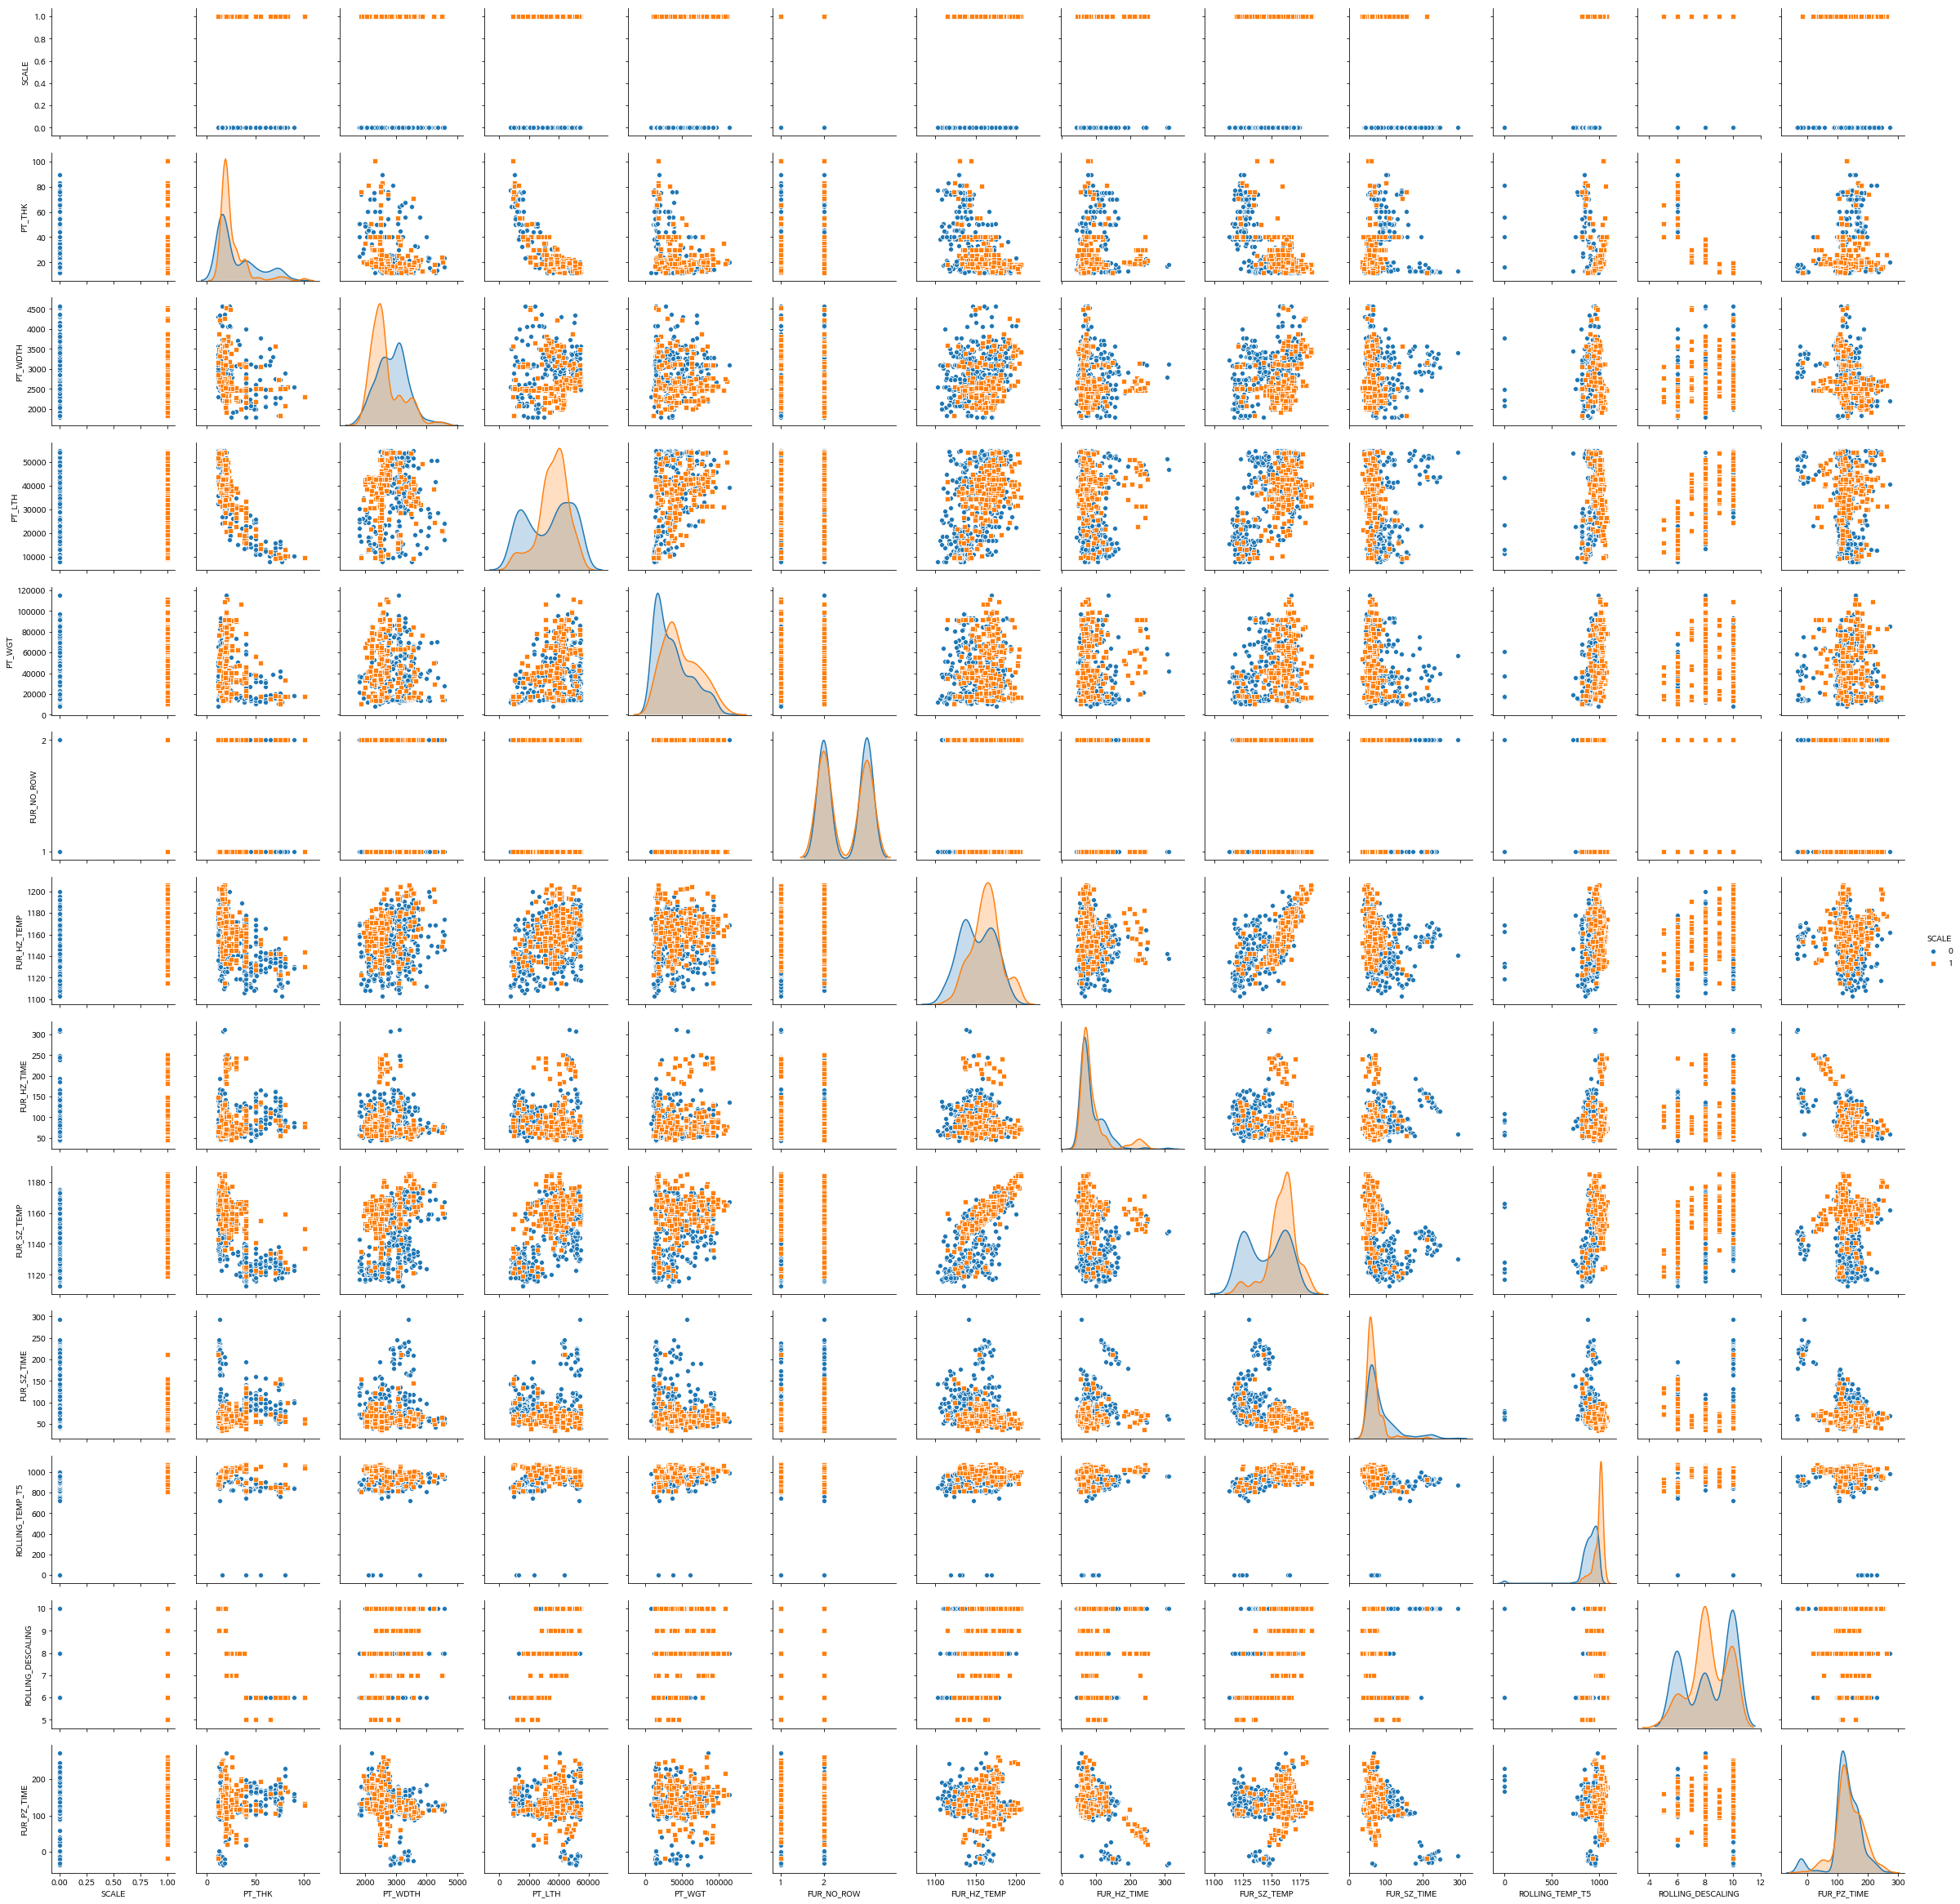

In [25]:
# 전반적인 관계 획인
sns.pairplot(df_drop_c1t3, hue="SCALE", markers=["o", "s"])

In [26]:
# ROLLING_TEMP_T5 이상치 데이터를 삭제 
df_rt_not0 = df_drop_c1t3.loc[df["ROLLING_TEMP_T5"] >0,:] 
df_rt_not0.shape

(711, 17)

- ROLLING_TEMP_T5가 0인 데이터 6개가 제거되었다. (717, 17) -> (711, 17)

In [27]:
df_rt_not0.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,FUR_PZ_TIME
0,0,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,934,적용,8,2조,107
1,0,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,937,적용,8,2조,108
2,0,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,889,적용,8,3조,111
3,0,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,885,적용,8,3조,123
4,0,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,873,적용,8,1조,132


##   3. 데이터 분석

In [28]:
# 데이터 분할

np.random.seed(seed =1234)
from sklearn.model_selection import train_test_split


# df_y = df_numeric["SCALE"]
# df_x = df_numeric.drop("SCALE", axis = 1, inplace = False)

df_train, df_test = train_test_split(df_rt_not0, test_size=0.30, random_state = 1234)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(497, 17)
test data size:(214, 17)


### 1. Logistic Regression

In [29]:
# 포뮬라 완성 함수 생성

for i, col in enumerate(df_train.columns):
    if i == 0:
        formula = col + " ~ "
    else:
        if df_train[col].dtype == 'O':
            col = "C("+col+")"
        if i == 1:
            formula += col
        else:
            formula += " + " + col
        
formula

'SCALE ~ C(STEEL_KIND) + PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + C(FUR_NO_ROW) + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING + C(WORK_GR) + FUR_PZ_TIME'

In [30]:
df_train_const = sm.add_constant(df_train)
df_train_const.head()

,const,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,FUR_PZ_TIME
231,1.0,1,C0,40.16,2463,16858,39270,2호기,2,1139,103,1147,51,1034,적용,6,2조,113
604,1.0,1,C0,20.18,2240,39679,84480,3호기,2,1170,78,1159,59,1044,적용,8,3조,205
286,1.0,0,C0,24.18,2848,31724,17150,2호기,2,1136,49,1160,71,976,적용,8,4조,142
58,1.0,0,T8,65.69,2498,11978,15430,3호기,1,1138,99,1129,86,847,적용,6,2조,167
416,1.0,0,T8,38.33,3099,16740,15610,3호기,2,1174,61,1148,91,870,적용,8,2조,116


In [31]:
log_model_ll = sm.Logit.from_formula(formula=formula, data= df_train_const)

log_result_ll = log_model_ll.fit(method='bfgs')
print(log_result_ll.summary())

         Current function value: 0.295902
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      472
Method:                           MLE   Df Model:                           24
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.5220
Time:                        09:22:05   Log-Likelihood:                -147.06
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 9.028e-54
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3050     23.925     -0.013      

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
y_pred_ll = log_result_ll.predict(df_test)
y_pred_class_ll = (y_pred_ll > .5).astype(int)
y_pred_class_ll.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_test["SCALE"], y_pred_class_ll)))

Accuracy: 0.864


- Iterations에러가 발생한다. 
- 모든 변수를 모델에 포함시킨 결과, 테스트 정확도는 0.864가 나왔다.
- 유의하지 않은 변수들을 제거하기로 한다.

In [33]:
log_model_ll2 = sm.Logit.from_formula(formula="""SCALE ~C(HSB) + C(WORK_GR) + PT_WDTH + FUR_HZ_TEMP 
+ FUR_SZ_TIME + ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_const)

log_result_ll2 = log_model_ll2.fit(method='bfgs')
print(log_result_ll2.summary())

         Current function value: 0.320919
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 41
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      487
Method:                           MLE   Df Model:                            9
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.4815
Time:                        09:22:06   Log-Likelihood:                -159.50
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 1.605e-58
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.9338   4355.807     -0.001      0.999 

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
y_pred_ll2 = log_result_ll2.predict(df_test)
y_pred_class_ll2 = (y_pred_ll2 > .5).astype(int)
y_pred_class_ll2.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_test["SCALE"], y_pred_class_ll2)))

Accuracy: 0.883


- Iterations에러가 발생한다. 
- 유의하지 않은 변수를 제거 후 모델링 결과, 테스트 정확도는 0.883이 나왔다.

In [35]:
log_model_ll3 = sm.Logit.from_formula(formula="""SCALE ~C(HSB) + C(WORK_GR) 
+ FUR_SZ_TIME + ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_const)

log_result_ll3 = log_model_ll3.fit(method='bfgs')
print(log_result_ll3.summary())

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.319429
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      489
Method:                           MLE   Df Model:                            7
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.4840
Time:                        09:22:06   Log-Likelihood:                -158.76
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 1.818e-60
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.6418   5528.078     -0.001      0.999 

In [36]:
y_pred_ll3 = log_result_ll3.predict(df_test)
y_pred_class_ll3 = (y_pred_ll3 > .5).astype(int)
y_pred_class_ll3.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_test["SCALE"], y_pred_class_ll3)))

Accuracy: 0.883


In [37]:
log_model_ll4 = sm.Logit.from_formula(formula="""SCALE ~C(HSB) + C(WORK_GR) 
+ ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_const)

log_result_ll4 = log_model_ll4.fit(method='bfgs')
print(log_result_ll4.summary())

         Current function value: 0.323769
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            6
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.4769
Time:                        09:22:06   Log-Likelihood:                -160.91
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 2.073e-60
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.5735   6864.140     -0.002      0.999 

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
y_pred_ll4 = log_result_ll4.predict(df_test)
y_pred_class_ll4 = (y_pred_ll4 > .5).astype(int)
y_pred_class_ll4.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_test["SCALE"], y_pred_class_ll4)))

Accuracy: 0.874


- 변수 4개(HSB, WORK_GR, ROLLING_TEMP_T5, ROLLING_DESCALING) 0.874의 정확도가 나오는 것을 확인할 수 있다.
- 도메인 지식과 함께 고려해 봤을 때, 스케일 발생의 주 원인은 압연공정에 있다고 추론할 수 있다.

### 변수의 중요도를 확인하기 위해 스케일링 후 로지스틱 리그레션 재실행

In [39]:
df_numeric_train = df_train.select_dtypes(exclude="object")
df_category_train = df_train.select_dtypes(include="object")

df_numeric_test = df_test.select_dtypes(exclude="object")
df_category_test = df_test.select_dtypes(include="object")

df_numeric_scaled_train = scale(df_numeric_train)
df_numeric_scaled_test = scale(df_numeric_test)

df_numeric_scaled_train = pd.DataFrame(df_numeric_scaled_train, columns=df_numeric_train.columns)
df_numeric_scaled_train["SCALE"] = np.where(df_numeric_scaled_train["SCALE"]>0,1,0)

df_numeric_scaled_test = pd.DataFrame(df_numeric_scaled_test, columns=df_numeric_test.columns)
df_numeric_scaled_test["SCALE"] = np.where(df_numeric_scaled_test["SCALE"]>0,1,0)

df_numeric_scaled_train.head()

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_PZ_TIME
0,1,0.599870,-0.657987,-1.295530,-0.093882,-0.779044,0.440887,-0.138787,-0.775260,1.429593,-1.459976,-0.435463
1,1,-0.452863,-1.098552,0.354218,1.734531,0.708099,-0.258197,0.540792,-0.565113,1.581317,-0.239441,1.493907
2,0,-0.242106,0.102629,-0.220855,-0.988474,-0.922961,-1.069134,0.597423,-0.249893,0.549594,-0.239441,0.172708
3,0,1.945029,-0.588840,-1.648309,-1.058036,-0.827016,0.329034,-1.158155,0.144132,-1.407643,-1.459976,0.696993
4,0,0.503449,0.598511,-1.304060,-1.050756,0.899988,-0.733574,-0.082156,0.275474,-1.058678,-0.239441,-0.372548


In [40]:
df_scaled_train = pd.concat([df_numeric_scaled_train, df_category_train.reset_index(drop= True)], axis=1)
df_scaled_test = pd.concat([df_numeric_scaled_test, df_category_test.reset_index(drop= True)], axis=1)

In [41]:
df_train_scaled_const = sm.add_constant(df_scaled_train)
log_model_ll_scaled = sm.Logit.from_formula(formula=formula, data= df_train_scaled_const)

log_result_ll_scaled = log_model_ll_scaled.fit(method='bfgs')
print(log_result_ll_scaled.summary())

         Current function value: 0.279928
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      472
Method:                           MLE   Df Model:                           24
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.5478
Time:                        09:22:06   Log-Likelihood:                -139.12
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 5.454e-57
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.3903      1.290      3.402      

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [42]:
y_pred_ll_scaled = log_result_ll_scaled.predict(df_scaled_test)
y_pred_class_ll_scaled = (y_pred_ll_scaled > .5).astype(int)
y_pred_class_ll_scaled.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_scaled_test["SCALE"], y_pred_class_ll_scaled)))

Accuracy: 0.855


- Iterations에러가 발생한다. 
- 모든 변수를 모델에 포함시킨 결과, 테스트 정확도는 0.855가 나왔다.
- 유의하지 않은 변수들을 제거하기로 한다.

In [43]:
log_model_ll_scaled2 = sm.Logit.from_formula(formula="""SCALE ~C(HSB) + PT_WDTH + FUR_HZ_TEMP 
+ ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_scaled_const)

log_result_ll_scaled2 = log_model_ll_scaled2.fit(method='bfgs')
print(log_result_ll_scaled2.summary())

         Current function value: 0.302987
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      491
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.5105
Time:                        09:22:06   Log-Likelihood:                -150.58
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 9.278e-66
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.6236     14.754      0.720      0.471 

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
y_pred_ll_scaled2 = log_result_ll_scaled2.predict(df_scaled_test)
y_pred_class_ll_scaled2 = (y_pred_ll_scaled2 > .5).astype(int)
y_pred_class_ll_scaled2.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_scaled_test["SCALE"], y_pred_class_ll_scaled2)))

Accuracy: 0.864


- Iterations에러가 발생한다. 
- 모든 변수를 모델에 포함시킨 결과, 테스트 정확도는 0.864가 나왔다.
- 유의하지 않은 변수들을 제거하기로 한다.

In [45]:
log_model_ll_scaled3 = sm.Logit.from_formula(formula="""SCALE ~ C(HSB) + FUR_HZ_TEMP 
+ ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_scaled_const)

log_result_ll_scaled3 = log_model_ll_scaled3.fit(method='bfgs')
print(log_result_ll_scaled3.summary())

         Current function value: 0.306046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  497
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            4
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.5056
Time:                        09:22:07   Log-Likelihood:                -152.10
converged:                      False   LL-Null:                       -307.64
                                        LLR p-value:                 4.445e-66
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.0968     26.373      0.459      0.646 

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
y_pred_ll_scaled3 = log_result_ll_scaled3.predict(df_scaled_test)
y_pred_class_ll_scaled3 = (y_pred_ll_scaled3 > .5).astype(int)
y_pred_class_ll_scaled3.head()

print("Accuracy: {0:.3f}".format(metrics.accuracy_score(df_scaled_test["SCALE"], y_pred_class_ll_scaled3)))

Accuracy: 0.874


- 변수 4개(HSB, WORK_GR, ROLLING_TEMP_T5, ROLLING_DESCALING) 0.874의 정확도가 나오는 것을 확인할 수 있다.
- 도메인 지식과 함께 고려해 봤을 때, 스케일 발생의 주 원인은 압연공정에 있다고 추론할 수 있다.

         Current function value: 0.306046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


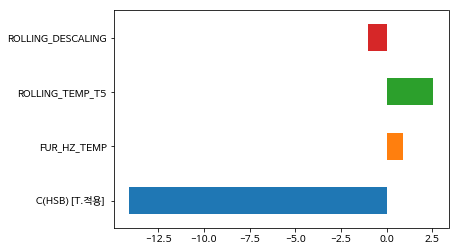

In [47]:
# 변수의 중요도 확인
log_model_ll_scaled3 = sm.Logit.from_formula(formula="""SCALE ~ C(HSB) + FUR_HZ_TEMP 
+ ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_scaled_const)

scaled_log_result = log_model_ll_scaled3.fit(method='bfgs')

ds_logg_scaled_coef = pd.DataFrame({'Coef': scaled_log_result.params.values[1:]},
                                  index = log_model_ll_scaled3.exog_names[1:])
ds_logg_scaled_coef.plot.barh(y="Coef", legend = False)

### 로지스틱 리그레션 결론

- 변수 4개(HSB, WORK_GR, ROLLING_TEMP_T5, ROLLING_DESCALING)만 사용해도 0.874의 정확도가 나오는 것을 확인할 수 있었다.
- 가장 영향이 큰 변수는 HSB적용 유무였으며, HSB를 적용하고, 압연 중 Descaling 횟수가 클수록 스케일 발생 확률이 줄어듬을 알 수 있었다.
- 또한, 도메인 지식처럼 가열 및 압연 공정의 가열온도의 증가는 스케일 발생 확률을 증가시키는 것을 알 수 있었다.

미리 선정한 잠재인자들(가열로 가열대온도, 가열로 균열대온도, HSB, 사상압연온도, 압연간 디스케일링 횟수, 판두께) 중 스케일발생 원인은 가열로 가열대 온도, HSB적용 유무, 사상압연온도, 압연간 디스케일링 횟수로 판단된다. 

### 한계
- Iterations 에러의 발생 원인과 그 해결 방안을 모르겠다.

### 2. 의사결정나무

#### 의사결정나무 모델링을 위한 데이터 처리

In [48]:
df_train_dummy = pd.get_dummies(df_train)
df_test_dummy = pd.get_dummies(df_test)

In [49]:
df_train_y = df_train_dummy["SCALE"]
df_train_x = df_train_dummy.drop("SCALE", axis = 1, inplace = False)
df_test_y = df_test_dummy["SCALE"]
df_test_x = df_test_dummy.drop("SCALE", axis = 1, inplace = False)


print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(497, 29)
train data Y size:(497,)
test data X size:(214, 29)
test data Y size:(214,)


In [50]:
train_accuracy =[]; test_accuracy= []
para_criterion =[]; para_max_depth=[]

n_iter_depth = 10

list_criterion = ["gini","entropy"]

for criterion in list_criterion:
    for depth in range(1, n_iter_depth+1):
        tree = DecisionTreeClassifier(criterion= criterion, max_depth= depth, random_state=1234)
        tree.fit(df_train_x, df_train_y)

        train_accuracy.append(tree.score(df_train_x, df_train_y))
        test_accuracy.append(tree.score(df_test_x, df_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)

In [51]:
ds_accuracy = pd.DataFrame()
ds_accuracy["Criterion"] = para_criterion
ds_accuracy["Depth"] = para_max_depth
ds_accuracy["TrainAccuracy"] = train_accuracy
ds_accuracy["TestAccuracy"] = test_accuracy
ds_accuracy.round(3)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.891,0.883
1,gini,2,0.932,0.935
2,gini,3,0.966,0.953
3,gini,4,0.972,0.963
4,gini,5,0.972,0.963
5,gini,6,0.978,0.963
6,gini,7,0.984,0.963
7,gini,8,0.986,0.967
8,gini,9,0.988,0.967
9,gini,10,0.998,0.967


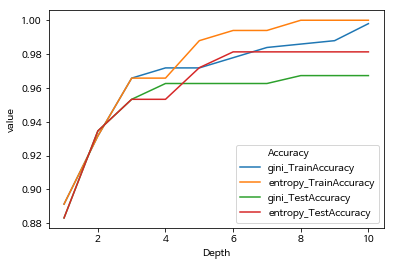

In [52]:
ds_accuracy_melt = pd.melt(ds_accuracy, id_vars=["Criterion", "Depth"])
ds_accuracy_melt["Accuracy"] = ds_accuracy_melt["Criterion"] + "_" + ds_accuracy_melt["variable"]
sns.lineplot(x="Depth", y="value", hue="Accuracy", data=ds_accuracy_melt)

Depth는 6으로 결정한다.

In [53]:
train_accuracy =[]; test_accuracy= []
para_criterion =[]; para_max_depth=[]; para_min_leaf_size =[]

max_depth = 6

list_min_leaf_size = [i for i in range(2, 20)]

for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree2 = DecisionTreeClassifier(criterion= criterion, max_depth= max_depth,
                                       min_samples_leaf = leafsize, random_state=1234)
        tree2.fit(df_train_x, df_train_y)
        train_accuracy.append(tree2.score(df_train_x, df_train_y))
        test_accuracy.append(tree2.score(df_test_x, df_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)

In [54]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["MinLeafSize"] = para_min_leaf_size
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,gini,6,2,0.978,0.963
1,gini,6,3,0.978,0.963
2,gini,6,4,0.988,0.972
3,gini,6,5,0.988,0.972
4,gini,6,6,0.988,0.972
5,gini,6,7,0.988,0.972
6,gini,6,8,0.988,0.972
7,gini,6,9,0.988,0.972
8,gini,6,10,0.988,0.972
9,gini,6,11,0.988,0.972


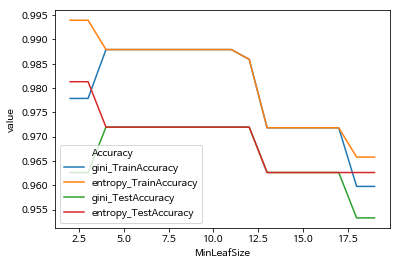

In [55]:
ds_accuracy2_melt = pd.melt(ds_accuracy2, id_vars=["Criterion", "Depth", "MinLeafSize"])

ds_accuracy2_melt["Accuracy"] = ds_accuracy2_melt["Criterion"] + "_" + ds_accuracy2_melt["variable"]
sns.lineplot(x="MinLeafSize", y="value", hue="Accuracy", data=ds_accuracy2_melt)

min_samples_leaf를 3으로 결정한다.

In [56]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_leaf=3,random_state=1234)
tree.fit(df_train_x, df_train_y)

ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = df_train_x.columns
ds_feature_importance['Importance'] = tree.feature_importances_

ds_feature_importance.sort_values("Importance", ascending =True, inplace=True)
ds_feature_importance.round(3)

,Feature,Importance
0,PT_THK,0.000
26,WORK_GR_2조,0.000
25,WORK_GR_1조,0.000
23,HSB_미적용,0.000
22,FUR_NO_ROW_2,0.000
21,FUR_NO_ROW_1,0.000
20,FUR_NO_3호기,0.000
19,FUR_NO_2호기,0.000
18,FUR_NO_1호기,0.000
17,STEEL_KIND_T8,0.000


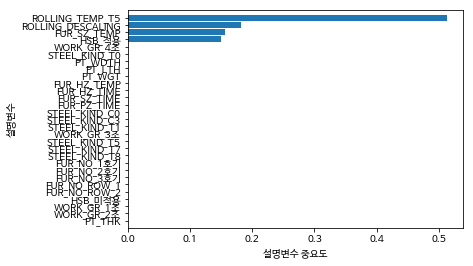

In [57]:
def plot_feature_importances(model):
    n_features = df_train_x.shape[1]
    plt.barh(range(n_features), ds_feature_importance['Importance'] , align="center")
    plt.yticks(np.arange(n_features), ds_feature_importance['Feature'] )
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)
    
plot_feature_importances(tree)

- 변수 중요도를 그림으로 그려 본 결과, ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP, HSB_적용 4개의 변수가 중요한 것을 알 수 있다.

### 변수의 중요도를 확인하기 위해 스케일링 후 의사결정나무 재실행

In [58]:
df_scaled_train_dummy = pd.get_dummies(df_scaled_train)
df_scaled_test_dummy = pd.get_dummies(df_scaled_test)
df_scaled_train_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,...,FUR_NO_2호기,FUR_NO_3호기,FUR_NO_ROW_1,FUR_NO_ROW_2,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,1,0.599870,-0.657987,-1.295530,-0.093882,-0.779044,0.440887,-0.138787,-0.775260,1.429593,...,1,0,0,1,0,1,0,1,0,0
1,1,-0.452863,-1.098552,0.354218,1.734531,0.708099,-0.258197,0.540792,-0.565113,1.581317,...,0,1,0,1,0,1,0,0,1,0
2,0,-0.242106,0.102629,-0.220855,-0.988474,-0.922961,-1.069134,0.597423,-0.249893,0.549594,...,1,0,0,1,0,1,0,0,0,1
3,0,1.945029,-0.588840,-1.648309,-1.058036,-0.827016,0.329034,-1.158155,0.144132,-1.407643,...,0,1,1,0,0,1,0,1,0,0
4,0,0.503449,0.598511,-1.304060,-1.050756,0.899988,-0.733574,-0.082156,0.275474,-1.058678,...,0,1,0,1,0,1,0,1,0,0


In [59]:
df_scaled_train_y = df_scaled_train_dummy["SCALE"]
df_scaled_train_x = df_scaled_train_dummy.drop("SCALE", axis = 1, inplace = False)
df_scaled_test_y = df_scaled_test_dummy["SCALE"]
df_scaled_test_x = df_scaled_test_dummy.drop("SCALE", axis = 1, inplace = False)


print("train data X size:{}".format(df_scaled_train_x.shape))
print("train data Y size:{}".format(df_scaled_train_y.shape))
print("test data X size:{}".format(df_scaled_test_x.shape))
print("test data Y size:{}".format(df_scaled_test_y.shape))

train data X size:(497, 29)
train data Y size:(497,)
test data X size:(214, 29)
test data Y size:(214,)


In [60]:
train_accuracy =[]; test_accuracy= []
para_criterion =[]; para_max_depth=[]

n_iter_depth = 10

list_criterion = ["gini","entropy"]

for criterion in list_criterion:
    for depth in range(1, n_iter_depth+1):
        tree = DecisionTreeClassifier(criterion= criterion, max_depth= depth, random_state=1234)
        tree.fit(df_scaled_train_x, df_scaled_train_y)

        train_accuracy.append(tree.score(df_scaled_train_x, df_scaled_train_y))
        test_accuracy.append(tree.score(df_scaled_test_x, df_scaled_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)

In [61]:
ds_accuracy = pd.DataFrame()
ds_accuracy["Criterion"] = para_criterion
ds_accuracy["Depth"] = para_max_depth
ds_accuracy["TrainAccuracy"] = train_accuracy
ds_accuracy["TestAccuracy"] = test_accuracy
ds_accuracy.round(3)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.891,0.827
1,gini,2,0.932,0.879
2,gini,3,0.966,0.897
3,gini,4,0.972,0.907
4,gini,5,0.972,0.907
5,gini,6,0.978,0.907
6,gini,7,0.984,0.907
7,gini,8,0.986,0.911
8,gini,9,0.988,0.911
9,gini,10,0.998,0.911


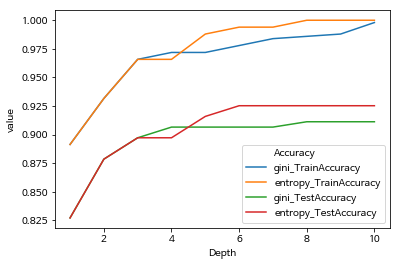

In [62]:
ds_accuracy_melt = pd.melt(ds_accuracy, id_vars=["Criterion", "Depth"])
ds_accuracy_melt["Accuracy"] = ds_accuracy_melt["Criterion"] + "_" + ds_accuracy_melt["variable"]
sns.lineplot(x="Depth", y="value", hue="Accuracy", data=ds_accuracy_melt)

- Depth가 6일때부터 테스트정확도가 안정적이기 때문에 Depth를 6으로 결정한다.

In [63]:
train_accuracy =[]; test_accuracy= []
para_criterion =[]; para_max_depth=[]; para_min_leaf_size =[]

max_depth = 6

list_min_leaf_size = [i for i in range(2, 20)]

for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree2 = DecisionTreeClassifier(criterion= criterion, max_depth= max_depth,
                                       min_samples_leaf = leafsize, random_state=1234)
        tree2.fit(df_scaled_train_x, df_scaled_train_y)
        train_accuracy.append(tree2.score(df_scaled_train_x, df_scaled_train_y))
        test_accuracy.append(tree2.score(df_scaled_test_x, df_scaled_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)

In [64]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["MinLeafSize"] = para_min_leaf_size
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,gini,6,2,0.978,0.907
1,gini,6,3,0.978,0.907
2,gini,6,4,0.988,0.916
3,gini,6,5,0.988,0.916
4,gini,6,6,0.988,0.916
5,gini,6,7,0.988,0.916
6,gini,6,8,0.988,0.916
7,gini,6,9,0.988,0.916
8,gini,6,10,0.988,0.916
9,gini,6,11,0.988,0.916


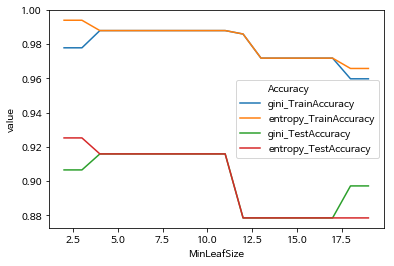

In [65]:
ds_accuracy2_melt = pd.melt(ds_accuracy2, id_vars=["Criterion", "Depth", "MinLeafSize"])

ds_accuracy2_melt["Accuracy"] = ds_accuracy2_melt["Criterion"] + "_" + ds_accuracy2_melt["variable"]
sns.lineplot(x="MinLeafSize", y="value", hue="Accuracy", data=ds_accuracy2_melt)

- criterion을 entropy로 하고 min_samples_leaf를 3으로 했을 때 가장 정확도가 높으므로, 이들을 파라미터값으로 결정한다.

In [66]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_leaf=3,random_state=1234)
tree.fit(df_scaled_train_x, df_scaled_train_y)

ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = df_scaled_train_x.columns
ds_feature_importance['Importance'] = tree.feature_importances_

ds_feature_importance.sort_values("Importance", ascending =True, inplace=True)
ds_feature_importance.round(3)

,Feature,Importance
0,PT_THK,0.000
26,WORK_GR_2조,0.000
25,WORK_GR_1조,0.000
23,HSB_미적용,0.000
22,FUR_NO_ROW_2,0.000
21,FUR_NO_ROW_1,0.000
20,FUR_NO_3호기,0.000
19,FUR_NO_2호기,0.000
18,FUR_NO_1호기,0.000
17,STEEL_KIND_T8,0.000


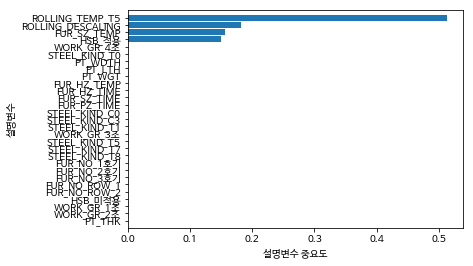

In [67]:
def plot_feature_importances(model):
    n_features = df_train_x.shape[1]
    plt.barh(range(n_features), ds_feature_importance['Importance'] , align="center")
    plt.yticks(np.arange(n_features), ds_feature_importance['Feature'] )
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)
    
plot_feature_importances(tree)

- 스케일 전과 같이 ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP, HSB_적용 4개의 변수가 중요한 것을 알 수 있다.

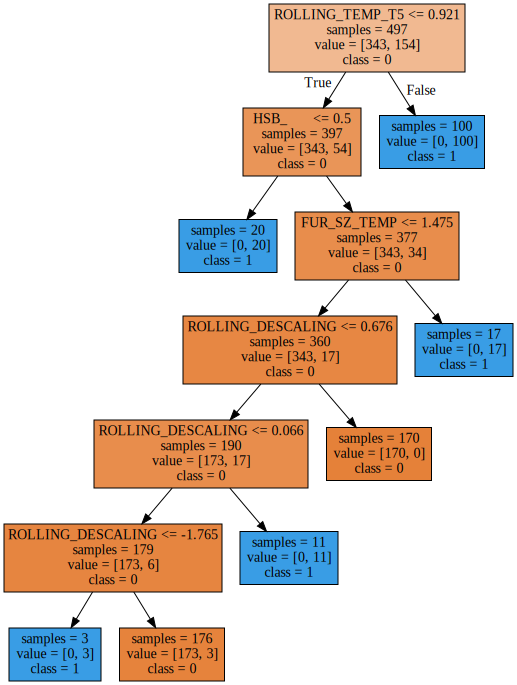

In [68]:
export_graphviz(tree, out_file="tree_종합실습2.dot", class_names=["0", "1"],
               feature_names = df_scaled_train_x.columns, impurity = False, filled=True)

with open("tree_종합실습2.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 의사결정나무 결론

- 변수 4개(HSB, WORK_GR, ROLLING_TEMP_T5, ROLLING_DESCALING)가 유의한 설명변수이며 0.925의 정확도가 나오는 것을 확인할 수 있었다.
- 가장 중요도가 큰 변수는 ROLLING_TEMP_T5였다.

미리 선정한 잠재인자들(가열로 가열대온도, 가열로 균열대온도, HSB, 사상압연온도, 압연간 디스케일링 횟수, 판두께) 중 스케일발생 중요 원인은 가열로 가열대 온도, HSB적용 유무, 사상압연온도, 압연간 디스케일링 횟수로 판단된다. 

### 한계
- 과적합 발생 가능성이 있으므로 주의해야 한다.

### 3. 랜덤포레스트

In [69]:
# create model 1.
model = RandomForestClassifier(random_state=1234)  
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_train_x, df_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_test_x, df_test_y, cv=kfold).mean()))

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/a

Accuracy on training set: 0.960
Accuracy on test set: 0.924


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [70]:
# create model 2.
model = RandomForestClassifier(random_state=1234)  
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_scaled_train_x, df_scaled_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_scaled_test_x, df_scaled_test_y, cv=kfold).mean()))

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/a

Accuracy on training set: 0.962
Accuracy on test set: 0.924


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/a

- 랜덤포레스트 파라미터 default 값으로 모델 kfold 교차검정 결과, 스케일 전후 데이터를 사용한 모델은 비슷한 정확도를 갖는다. 
- 또한 랜덤포레스트는 변수단위에 큰 영향을 받지 않고, 중요도를 비교하기 좋은 스케일한 데이터를 사용하기로 한다.

In [71]:
n_iter_tree = 30

train_accuracy = []
test_accuracy = []

for n_tree in range(n_iter_tree):
    rf1 = RandomForestClassifier(n_estimators=n_tree +1, random_state=1234)
    rf1.fit(df_scaled_train_x, df_scaled_train_y)
    train_accuracy.append(rf1.score(df_scaled_train_x, df_scaled_train_y))
    test_accuracy.append(rf1.score(df_scaled_test_x, df_scaled_test_y))
    
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["NumberofTree"] = [n_tree +1 for n_tree in range(n_iter_tree)]
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy
ds_accuracy1

,NumberofTree,TrainAccuracy,TestAccuracy
0,1,0.977867,0.892523
1,2,0.961771,0.831776
2,3,0.993964,0.892523
3,4,0.985915,0.859813
4,5,0.997988,0.883178
5,6,0.995976,0.869159
6,7,0.997988,0.883178
7,8,0.997988,0.883178
8,9,0.997988,0.892523
9,10,0.997988,0.892523


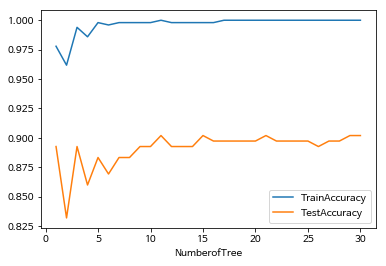

In [72]:
ds_accuracy1.set_index("NumberofTree", inplace = False).plot.line()

- 트리 개수에 따른 정확도의 변화를 확인하였다. n_estimators는 11로 결정한다.

In [73]:
train_accuracy = []
test_accuracy = []

para_criterion = ["gini", "entropy"]

for criterion in para_criterion:
    rf2 = RandomForestClassifier(criterion=criterion, random_state=1234, n_estimators=11)
    rf2.fit(df_scaled_train_x, df_scaled_train_y)
    train_accuracy.append(rf2.score(df_scaled_train_x, df_scaled_train_y))
    test_accuracy.append(rf2.score(df_scaled_test_x, df_scaled_test_y))
    
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2

,Criterion,TrainAccuracy,TestAccuracy
0,gini,1.0,0.901869
1,entropy,1.0,0.901869


In [74]:
train_accuracy = []
test_accuracy = []

para_max_depth = [i+1 for i in range(15)]*2
n_iter_depth = 15

para_criterion = ["gini"]*n_iter_depth + ["entropy"]*n_iter_depth

for (criterion, depth) in zip(para_criterion, para_max_depth):
    rf3 = RandomForestClassifier(criterion=criterion, max_depth=depth,n_estimators=11, random_state=1234)
    rf3.fit(df_scaled_train_x, df_scaled_train_y)
    train_accuracy.append(rf3.score(df_scaled_train_x, df_scaled_train_y))
    test_accuracy.append(rf3.score(df_scaled_test_x, df_scaled_test_y))

ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.724346,0.686916
1,gini,2,0.931590,0.859813
2,gini,3,0.929577,0.873832
3,gini,4,0.949698,0.887850
4,gini,5,0.959759,0.892523
5,gini,6,0.971831,0.887850
6,gini,7,0.991952,0.892523
7,gini,8,0.997988,0.906542
8,gini,9,0.997988,0.892523
9,gini,10,1.000000,0.892523


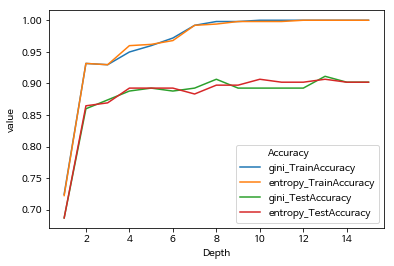

In [75]:
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars =["Criterion", "Depth"])
ds_accuracy3_melt["Accuracy"] = ds_accuracy3_melt["Criterion"] + "_" + ds_accuracy3_melt["variable"]
sns.lineplot(x="Depth", y="value", hue="Accuracy", data=ds_accuracy3_melt)

- Depth는 10, criterion은 entropy로 결정한다.

In [76]:
train_accuracy = []
test_accuracy = []

n_depth = 10
n_iter_min_leaf_size = 10
para_criterion = ["entropy"]*n_iter_min_leaf_size
para_min_leaf_size = [i+1 for i in range(n_iter_min_leaf_size)]

for (criterion, leafsize) in zip(para_criterion, para_min_leaf_size):
    rf4 = RandomForestClassifier(criterion=criterion, max_depth=n_depth, min_samples_leaf=leafsize,
                                 n_estimators=11, random_state=1234)
    rf4.fit(df_scaled_train_x, df_scaled_train_y)
    train_accuracy.append(rf4.score(df_scaled_train_x, df_scaled_train_y))
    test_accuracy.append(rf4.score(df_scaled_test_x, df_scaled_test_y))

ds_accuracy4 = pd.DataFrame()
ds_accuracy4["Criterion"] = para_criterion
ds_accuracy4["Depth"] = n_depth
ds_accuracy4["MinLeafSize"] = para_min_leaf_size
ds_accuracy4["TrainAccuracy"] = train_accuracy
ds_accuracy4["TestAccuracy"] = test_accuracy
ds_accuracy4

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,entropy,10,1,0.997988,0.906542
1,entropy,10,2,0.993964,0.892523
2,entropy,10,3,0.987928,0.901869
3,entropy,10,4,0.985915,0.911215
4,entropy,10,5,0.989940,0.901869
5,entropy,10,6,0.977867,0.887850
6,entropy,10,7,0.971831,0.883178
7,entropy,10,8,0.955734,0.864486
8,entropy,10,9,0.941650,0.850467
9,entropy,10,10,0.931590,0.855140


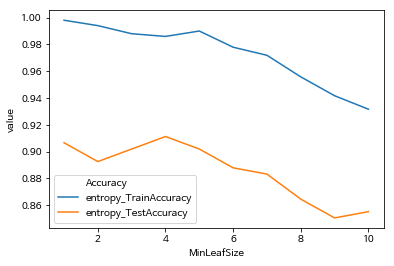

In [77]:
ds_accuracy4_melt = pd.melt(ds_accuracy4, id_vars =["Criterion", "Depth", "MinLeafSize"])
ds_accuracy4_melt["Accuracy"] = ds_accuracy4_melt["Criterion"] + "_" + ds_accuracy4_melt["variable"]
sns.lineplot(x="MinLeafSize", y="value", hue="Accuracy", data=ds_accuracy4_melt)

- min_samples_leaf는 4로 결정한다.

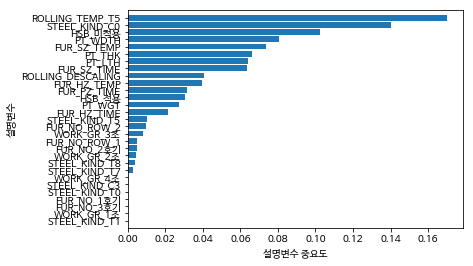

In [78]:
rf_model = RandomForestClassifier(criterion="entropy", max_depth=4, min_samples_leaf=4
                                  , n_estimators = 11, random_state=1234)
rf_model.fit(df_scaled_train_x, df_scaled_train_y)

ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = df_scaled_train_x.columns
ds_feature_importance["Importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values(by="Importance", ascending = True, inplace=True)

def plot_feature_importances(model):
    n_features = df_scaled_train_x.shape[1]
    plt.barh(range(n_features), ds_feature_importance['Importance'], align="center")
    plt.yticks(np.arange(n_features), ds_feature_importance['Feature'])
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)
    
plot_feature_importances(rf_model)


In [79]:
# kfold accuracy
model = RandomForestClassifier(criterion="entropy", max_depth=4, min_samples_leaf=4
                                  , n_estimators = 11, random_state=1234)
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_scaled_train_x, df_scaled_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_scaled_test_x, df_scaled_test_y, cv=kfold).mean()))

Accuracy on training set: 0.926
Accuracy on test set: 0.910


### 랜덤포레스트 결론
- ROLLING_TEMP_T5가 가장 유의한 변수로 보인다.
- STEEL_KIND_C0이 다음으로 유의한 변수로 보인다.
- Kfold 모델평가 결과, 정확도는 0.91로 괜찮은 모델을 생성하였다.

### 4. 그래디언트 부스팅

In [80]:
df_dummy = pd.get_dummies(df_rt_not0)
df_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,...,FUR_NO_2호기,FUR_NO_3호기,FUR_NO_ROW_1,FUR_NO_ROW_2,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1144,116,1133,59,934,...,0,0,1,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,1144,122,1135,53,937,...,0,0,0,1,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1129,116,1121,55,889,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,1152,125,1127,68,885,...,1,0,0,1,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1140,134,1128,48,873,...,0,1,1,0,0,1,1,0,0,0


In [81]:
from sklearn.model_selection import train_test_split


df_y = df_rt_not0["SCALE"]
df_x = df_dummy.drop("SCALE",  axis =1)

df_train_x, df_test_x, df_train_y, df_test_y =\
train_test_split(df_x, df_y, test_size=0.30, random_state = 1234)

print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(497, 29)
train data Y size:(497,)
test data X size:(214, 29)
test data Y size:(214,)


In [82]:
# 스케일에 영향을 많이 받는 SVM이므로 스케일링한다.
df_train_x_scaled = scale(df_train_x,axis = 0)
df_test_x_scaled = scale(df_test_x,axis = 0)
pd.DataFrame(df_train_x_scaled, columns=df_train_x.columns).head()

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,...,FUR_NO_2호기,FUR_NO_3호기,FUR_NO_ROW_1,FUR_NO_ROW_2,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0.599870,-0.657987,-1.295530,-0.093882,-0.779044,0.440887,-0.138787,-0.775260,1.429593,-1.459976,...,1.362469,-0.679533,-0.978107,0.978107,-0.215211,0.215211,-0.58587,1.812314,-0.567282,-0.604471
1,-0.452863,-1.098552,0.354218,1.734531,0.708099,-0.258197,0.540792,-0.565113,1.581317,-0.239441,...,-0.733962,1.471600,-0.978107,0.978107,-0.215211,0.215211,-0.58587,-0.551781,1.762793,-0.604471
2,-0.242106,0.102629,-0.220855,-0.988474,-0.922961,-1.069134,0.597423,-0.249893,0.549594,-0.239441,...,1.362469,-0.679533,-0.978107,0.978107,-0.215211,0.215211,-0.58587,-0.551781,-0.567282,1.654340
3,1.945029,-0.588840,-1.648309,-1.058036,-0.827016,0.329034,-1.158155,0.144132,-1.407643,-1.459976,...,-0.733962,1.471600,1.022383,-1.022383,-0.215211,0.215211,-0.58587,1.812314,-0.567282,-0.604471
4,0.503449,0.598511,-1.304060,-1.050756,0.899988,-0.733574,-0.082156,0.275474,-1.058678,-0.239441,...,-0.733962,1.471600,-0.978107,0.978107,-0.215211,0.215211,-0.58587,1.812314,-0.567282,-0.604471


In [83]:
# create model 1.
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_train_x, df_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_test_x, df_test_y, cv=kfold).mean()))

Accuracy on training set: 0.924
Accuracy on test set: 0.910


In [84]:
# create model 2.
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_train_x_scaled, df_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_test_x_scaled, df_test_y, cv=kfold).mean()))

Accuracy on training set: 0.926
Accuracy on test set: 0.910


스케일링한 결과 테스트셋 정확도가 비슷한 것을 확인할 수 있다. -> 원래 데이터셋 사용

In [85]:
train_accuracy = []
test_accuracy = []

for lr in range(1, 100, 5):
    gb = GradientBoostingClassifier(learning_rate=lr/100, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
ds_accuracy = pd.DataFrame()
ds_accuracy["LearningRate"] = [lr/100 for lr in range(1, 100, 5)]
ds_accuracy["TrainAccuracy"] = train_accuracy
ds_accuracy["TestAccuracy"] = test_accuracy
ds_accuracy.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.01,0.966,0.953
1,0.06,0.998,0.972
2,0.11,1.000,0.972
3,0.16,1.000,0.981
4,0.21,1.000,0.977
5,0.26,1.000,0.981
6,0.31,1.000,0.981
7,0.36,1.000,0.981
8,0.41,1.000,0.977
9,0.46,1.000,0.981


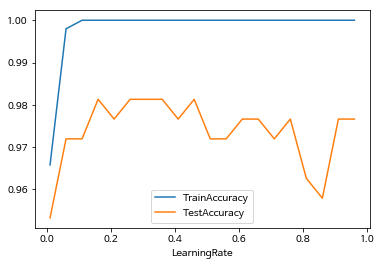

In [86]:
ds_accuracy.set_index("LearningRate", inplace= False).plot.line()

- learning late 는 0.16으로 결정한다.

In [87]:
para_estimators = [estimators for estimators in range(10, 150, 10)]
lr = 0.16

train_accuracy = []
test_accuracy = []

for estimators in para_estimators:
    gb2 = GradientBoostingClassifier(learning_rate = lr,n_estimators=estimators, random_state=1234)
    gb2.fit(df_train_x, df_train_y)
    train_accuracy.append(gb2.score(df_train_x, df_train_y))
    test_accuracy.append(gb2.score(df_test_x, df_test_y))
    
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Estimators"] = para_estimators
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.972,0.963
1,20,0.974,0.963
2,30,0.996,0.972
3,40,1.000,0.977
4,50,1.000,0.972
5,60,1.000,0.977
6,70,1.000,0.977
7,80,1.000,0.977
8,90,1.000,0.981
9,100,1.000,0.981


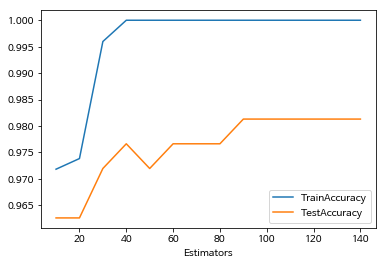

In [88]:
ds_accuracy2.set_index("Estimators", inplace = False).plot.line()

- estimators 는 40으로 결정한다.

In [89]:
lr = 0.16 ; n_estimators = 40
para_max_depth = [i+1 for i in range(10)]

train_accuracy = []
test_accuracy = []

for depth in para_max_depth:
    gb3 = GradientBoostingClassifier(learning_rate=lr,n_estimators=n_estimators,max_depth=depth, random_state=1234)
    gb3.fit(df_train_x, df_train_y)
    train_accuracy.append(gb3.score(df_train_x, df_train_y))
    test_accuracy.append(gb3.score(df_test_x, df_test_y))
    
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["MaxDepth"] = para_max_depth
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3.round(3)

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.972,0.963
1,2,0.984,0.963
2,3,1.000,0.977
3,4,1.000,0.977
4,5,1.000,0.991
5,6,1.000,0.986
6,7,1.000,0.986
7,8,1.000,0.972
8,9,1.000,0.977
9,10,1.000,0.967


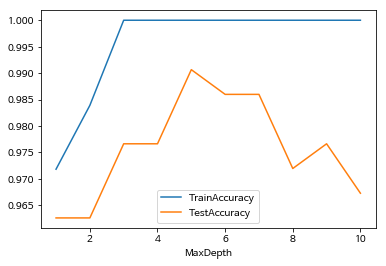

In [90]:
ds_accuracy3.set_index("MaxDepth", inplace = False).plot.line()

- Maxdepth는 3으로 결정한다.

In [91]:
lr = 0.16 ; n_estimators = 40; max_depth = 3;
para_min_leaf_size = [i+1 for i in range(20)]

train_accuracy = []
test_accuracy = []

for leafsize in para_min_leaf_size:
    gb4 = GradientBoostingClassifier(learning_rate=lr,n_estimators=n_estimators,max_depth=max_depth
                                     ,min_samples_leaf=leafsize,
                                     random_state=1234)
    gb4.fit(df_train_x, df_train_y)
    train_accuracy.append(gb4.score(df_train_x, df_train_y))
    test_accuracy.append(gb4.score(df_test_x, df_test_y))
    
ds_accuracy4 = pd.DataFrame()
ds_accuracy4["MinLeafSize"] = para_min_leaf_size
ds_accuracy4["TrainAccuracy"] = train_accuracy
ds_accuracy4["TestAccuracy"] = test_accuracy
ds_accuracy4.round(3)

,MinLeafSize,TrainAccuracy,TestAccuracy
0,1,1.000,0.977
1,2,1.000,0.972
2,3,1.000,0.977
3,4,0.992,0.963
4,5,0.992,0.963
5,6,0.992,0.963
6,7,0.992,0.963
7,8,0.992,0.963
8,9,0.992,0.963
9,10,0.994,0.963


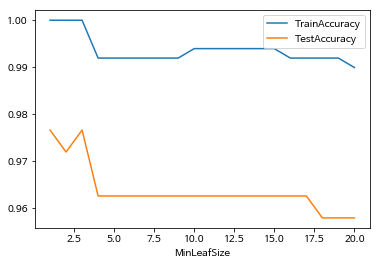

In [92]:
ds_accuracy4.set_index("MinLeafSize", inplace = False).plot.line()

- min_samples_leaf는 15로 결정한다.

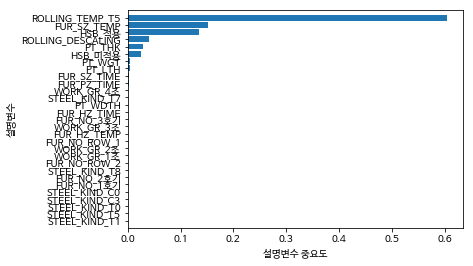

In [93]:
gb_model = GradientBoostingClassifier(learning_rate=0.16, max_depth=3, min_samples_leaf=15,
                                     n_estimators= 40, random_state = 1234)
gb_model.fit(df_train_x, df_train_y)

ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = df_train_x.columns
ds_feature_importance["Importance"] = gb_model.feature_importances_
ds_feature_importance.sort_values(by="Importance", ascending = True, inplace=True)

def plot_feature_importances(model):
    n_features = df_train_x.shape[1]
    plt.barh(range(n_features), ds_feature_importance['Importance'], align="center")
    plt.yticks(np.arange(n_features), ds_feature_importance['Feature'])
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)
    
plot_feature_importances(gb_model)

In [94]:
# kfold 
gb_uncustomized = GradientBoostingClassifier(learning_rate=0.16, max_depth=3, min_samples_leaf=15,
                                     n_estimators= 40, random_state = 1234)
kfold = KFold(n_splits=10, shuffle=True, random_state=1234) 

print("Accuracy on training set: {:.3f}".format(cross_val_score(model, df_train_x, df_train_y, cv=kfold).mean()))
print("Accuracy on test set: {:.3f}".format(cross_val_score(model, df_test_x, df_test_y, cv=kfold).mean()))

Accuracy on training set: 0.924
Accuracy on test set: 0.910


### 그래디언트부스팅 결론
- ROLLING_TEMP_T5가 가장 유의한 변수로 보인다.
- FUR_SZ_TEMP가 다음으로 유의한 변수로 보인다.
- PT_THK, PT_WGT,PT_LTH등 강판 치수에 대한 변수들 또한 유의함을 알 수 있다. 
- Kfold 모델평가 결과, 정확도는 0.91로 괜찮은 모델을 생성하였다.

## 4. 모델 평가

In [95]:
model = ["Logistic","DesisonTree","RandomForest", "GradientBoosting"]

train_accuracy = []
test_accuracy = []
model_f1_score = []
time_socre = []

In [96]:
# 로지스틱 리그레션
log_model = sm.Logit.from_formula(formula="""SCALE ~ C(HSB) + FUR_HZ_TEMP 
+ ROLLING_TEMP_T5 + ROLLING_DESCALING """, data= df_train_scaled_const)

start= time.time()

y_pred_train = log_model.fit(method='bfgs').predict(df_scaled_train)
y_pred_train = (y_pred_train > .5).astype(int)
accu_train_ll = metrics.accuracy_score(df_scaled_train["SCALE"], y_pred_train)

y_pred_test = log_model.fit(method='bfgs').predict(df_scaled_test)
y_pred_test = (y_pred_test > .5).astype(int)
accu_test_ll = metrics.accuracy_score(df_scaled_test["SCALE"], y_pred_test)

train_accuracy.append(accu_train_ll)
test_accuracy.append(accu_test_ll)
model_f1_score.append(f1_score(df_scaled_test["SCALE"], y_pred_test))
time_socre.append(time.time()-start)

         Current function value: 0.306046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.306046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [97]:
# 의사결정나무
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_leaf=3,random_state=1234)

start= time.time()

tree.fit(df_scaled_train_x, df_scaled_train_y)
train_accuracy.append(tree.score(df_scaled_train_x, df_scaled_train_y))
test_accuracy.append(tree.score(df_scaled_test_x, df_scaled_test_y))
model_f1_score.append(f1_score(df_scaled_test_y, tree.predict(df_scaled_test_x)))
time_socre.append(time.time()-start)

In [98]:
# 랜덤포레스트
rf = RandomForestClassifier(criterion="entropy", max_depth=4, min_samples_leaf=4
                                  , n_estimators = 11, random_state=1234)
rf.fit(df_scaled_train_x, df_scaled_train_y)
start= time.time()

rf.fit(df_scaled_train_x, df_scaled_train_y)
train_accuracy.append(rf.score(df_scaled_train_x, df_scaled_train_y))
test_accuracy.append(rf.score(df_scaled_test_x, df_scaled_test_y))
model_f1_score.append(f1_score(df_scaled_test_y, rf.predict(df_scaled_test_x)))
time_socre.append(time.time()-start)

In [99]:
# 그래디언트 부스팅
gb = GradientBoostingClassifier(learning_rate=0.16, max_depth=3, min_samples_leaf=15,
                                     n_estimators= 40, random_state = 1234)
gb.fit(df_train_x, df_train_y)
start= time.time()

gb.fit(df_train_x, df_train_y)
train_accuracy.append(gb.score(df_train_x, df_train_y))
test_accuracy.append(gb.score(df_test_x, df_test_y))
model_f1_score.append(f1_score(df_test_y, gb.predict(df_test_x)))
time_socre.append(time.time()-start)

In [100]:
# 통합 테이블
ds_eval = pd.DataFrame(index=model)
ds_eval["TrainAccuracy"] = train_accuracy
ds_eval["TestAccuracy"] = test_accuracy
ds_eval["F1Score"] = model_f1_score
ds_eval["Time"] = time_socre
ds_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,Time
Logistic,0.873,0.874,0.811,0.035
DesisonTree,0.994,0.925,0.882,0.008
RandomForest,0.950,0.883,0.803,0.020
GradientBoosting,0.994,0.963,0.944,0.035


- 모델 분석 결과, 테스트 정확도가 가장 높은 모델은 그래디언트 부스팅 모델이였다.
- 또한 F1-score는 그래디언트 부스팅 > 의사결정나무 > 로지스틱리그래션 > 랜덤포레스트 순으로 높았다.
- 모델링 시간은 로지스틱 리그래션이 가장 오래 걸렸으며, 랜덤포레스트가 가장 빠른 모델링 속도를 보였다.

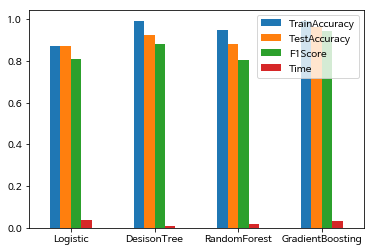

In [101]:
ds_eval.plot.bar(rot=0)

In [102]:
ds_logg_scaled_coef.sort_values("Coef", ascending =False, inplace=True)
ds_logg_scaled_coef.head(6)

,Coef
ROLLING_TEMP_T5,2.554194
FUR_HZ_TEMP,0.912767
ROLLING_DESCALING,-1.044698
C(HSB)[T.적용],-14.099672


In [103]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = df_scaled_train_x.columns
ds_feature_importance['Importance'] = tree.feature_importances_

ds_feature_importance.sort_values("Importance", ascending =False, inplace=True)
ds_feature_importance.loc[ds_feature_importance["Importance"] >0,:].head(6)

,Feature,Importance
8,ROLLING_TEMP_T5,0.512096
9,ROLLING_DESCALING,0.182260
6,FUR_SZ_TEMP,0.156361
24,HSB_적용,0.149283


In [104]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = df_scaled_train_x.columns
ds_feature_importance['Importance'] = rf.feature_importances_

ds_feature_importance.sort_values(by="Importance", ascending =False, inplace=True)

ds_feature_importance.loc[ds_feature_importance["Importance"] >0,:].head(6)

,Feature,Importance
8,ROLLING_TEMP_T5,0.169835
11,STEEL_KIND_C0,0.140307
23,HSB_미적용,0.102376
1,PT_WDTH,0.080503
6,FUR_SZ_TEMP,0.073830
0,PT_THK,0.066035


In [105]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = df_scaled_train_x.columns
ds_feature_importance['Importance'] = gb.feature_importances_

ds_feature_importance.sort_values(by="Importance", ascending =False, inplace=True)

ds_feature_importance.loc[ds_feature_importance["Importance"] >0,:].head(6)

,Feature,Importance
8,ROLLING_TEMP_T5,0.603470
6,FUR_SZ_TEMP,0.151795
24,HSB_적용,0.135272
9,ROLLING_DESCALING,0.040302
0,PT_THK,0.028971
23,HSB_미적용,0.024241


## 5. 최종 결론

지금까지 POSCO 공장의 **"Scale 불량 발생 증가"** 그 원인을 분석해 보았다.
수집된 데이터를 가지고 **Logistic Regression, Decision Tree, Random Forest, Gradient Boosting** 모델 분석을 통해 불량발생의 근본 원인을 찾고 개선을 위한 최적의 조건을 도출하고자 하였다.

모델 분석 결과, 테스트 **정확도**가 가장 높은 모델은 **그래디언트 부스팅** 모델로 그 정확도는 **0.944**였다.
또한 **F1-score**는 **그래디언트 부스팅 > 의사결정나무 > 로지스틱리그래션 > 랜덤포레스트** 순으로 높았으며 **모델링 시간**은 로지스틱 리그래션이 가장 오래 걸렸으며, 랜덤포레스트가 가장 빠른 모델링 속도를 보였다.

----------------------------------------------------------

또한 **잠재 근본 원인**을 찾기 위해 **변수의 중요도**를 탐색하였다.



먼저 **로지스틱 리그래션**의 경우 다음과 같은 변수들이 잠재원인으로 도출되었다.
- ROLLING_TEMP_T5	
- FUR_HZ_TEMP	
- ROLLING_DESCALING
- C(HSB)[T.적용]

모델 해석 결과, 스케일 불량은 **사상압연온도**가 높고 **가열대 온도**가 높을수록 발생할 확률이 올라갔으며, **HSB**를 적용하고 **디스케일링 횟수**가 높을수록 스케일 발생 확률이 줄어들 것으로 분석되었다.


----------------------------------------------------------

둘째로, **의사결정나무**의 경우 다음과 같은 변수들이 잠재원인으로 도출되었다.
- ROLLING_TEMP_T5	
- ROLLING_DESCALING	
- FUR_SZ_TEMP	
- HSB_적용

모델 해석 결과, **사상압연온도, 균열대 온도, HSB적용 유무, 디스케일링 횟수**가 스케일 불량 발생에 유의한 변수로 분석되었다.

----------------------------------------------------------

셋째로, **랜덤포레스트**의 경우 다음과 같은 변수들이 잠재원인으로 도출되었다.
- ROLLING_TEMP_T5	
- STEEL_KIND_C0	
- HSB_미적용	
- PT_WDTH	
- FUR_SZ_TEMP	
- PT_THK

모델 해석 결과, **사상압연온도, 강종(C0), HSB적용 유무, 균열대 온도, 강판 두께 및 폭**이 스케일 불량 발생에 주 잠재 변수로 분석되었다.


----------------------------------------------------------

마지막으로, **그래디언트 부스팅**의 경우 다음과 같은 변수들이 잠재원인으로 도출되었다.
- ROLLING_TEMP_T5
- FUR_SZ_TEMP
- HSB_적용
- ROLLING_DESCALING
- PT_THK
- HSB_미적용	

모델 해석 결과, **사상압연온도, 균열대 온도, HSB적용 유무, 디스케일링 횟수, 강판 두께**가 스케일 불량 발생에 주 잠재 변수로 분석되었다.


----------------------------------------------------------

종합적으로 봤을 때, 압연공정에서 스케일 발생의 **주 잠재원인**은 **사상압연온도(ROLLING_TEMP_T5), 디스케일링 횟수(ROLLING_DESCALING), 
HSB적용 유무(HSB), 가열대 온도(FUR_SZ_TEMP)**로 파악된다.

즉, 스케일 발생 잠재원인은 압연공정 요인과, 가열공정 요인으로 나뉘며, 가열로에서 발생하는 1차 스케일과, 압연공정에서 발생하는 2차 스케일이, 압연공정 이후 발견하는 스케일로 나타난 것으로 분석된다.


또한 이는 사전 답사에서 얻은 도메인 지식과 부합하는 결과로써 도메인 지식이 데이터 분석에 얼마나 중요한 역할을 하는지 다시한번 느끼는 계기가 되었다.
   



                                             < ref. Domain knowledge >

                                             압연공정에서 발생한 Scale은 "2차 Scale"으로 점형태를 띈다.
                                             Scale은 가열로에서 너무 오래 있으면 융착됨으로 가열로 온도 조건과 시간이 중요하다.
                                             압연 종료 온도가 높으면 발생할 확률이 높다.


### !! 한계점

- 데이터 720개는 공정의 잠재원인을 분석하기에 너무 적은 데이터라 파악된다.
- 또한, 강종과 스펙에서 레이블별 데이터의 불균형이 심해 데이터 분석에 변수로 사용할 수 없었던 점이 아쉽다.
- 더하여 로지스틱 리그래션의 Iteration에러의 원인과 그 해결 방안에 대한 정보가 있으면 보다 효과적인 모델링 작업이 가능했을 것이다.
